In [1]:
# download_sequences.py
from Bio import Entrez, SeqIO
import os
import shutil
import tempfile
import time

def download_all_sequences(virus_name, save_path):
    try:
        # Set your NCBI email
        Entrez.email = "ghorbani.abozar@gmail.com"

        # Search for all genome sequences of the specified virus in NCBI nucleotide database
        search_term = f"{virus_name}[Organism] AND genome[Title]"
        handle = Entrez.esearch(db="nucleotide", term=search_term, retmax=10)  # Adjust retmax as needed
        record = Entrez.read(handle)
        handle.close()

        if record["Count"] == "0":
            print(f"No records found for {virus_name}. Please check the virus name.")
            return

        # Create the save path if it doesn't exist
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Fetch and save all sequences directly to the specified save path
        for seq_id in record["IdList"]:
            handle = Entrez.efetch(db="nucleotide", id=seq_id, rettype="fasta", retmode="text")
            seq_record = SeqIO.read(handle, "fasta")
            handle.close()

            # Save each sequence to the specified save path
            filename = f"{virus_name}_{seq_id}.fasta"
            filepath = os.path.join(save_path, filename)
            SeqIO.write(seq_record, filepath, "fasta")
            print(f"Sequence {seq_id} saved: {filepath}")

        print(f"All sequences downloaded and saved to {save_path}")
        return save_path

    except Entrez.EntrezError as e:
        print(f"NCBI error: {e}")
    except IOError as e:
        print(f"IO error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    try:
        # Specify the virus name and the save path
        virus_name = "Tomato Mosaic Virus"
        save_path = r"C:\Users\AFRAA\OneDrive\Documents"

        # Download all sequences directly to the specified save path
        download_all_sequences(virus_name, save_path)

        # Add a delay to avoid being blocked by the NCBI servers
        time.sleep(2)

    except KeyboardInterrupt:
        print("The download was interrupted by the user.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


Sequence 2744300783 saved: C:\Users\AFRAA\OneDrive\Documents\Tomato Mosaic Virus_2744300783.fasta
Sequence 2742242734 saved: C:\Users\AFRAA\OneDrive\Documents\Tomato Mosaic Virus_2742242734.fasta
Sequence 2742242729 saved: C:\Users\AFRAA\OneDrive\Documents\Tomato Mosaic Virus_2742242729.fasta
Sequence 2742242724 saved: C:\Users\AFRAA\OneDrive\Documents\Tomato Mosaic Virus_2742242724.fasta
Sequence 2085776112 saved: C:\Users\AFRAA\OneDrive\Documents\Tomato Mosaic Virus_2085776112.fasta
Sequence 2701262864 saved: C:\Users\AFRAA\OneDrive\Documents\Tomato Mosaic Virus_2701262864.fasta
Sequence 2701262859 saved: C:\Users\AFRAA\OneDrive\Documents\Tomato Mosaic Virus_2701262859.fasta
Sequence 2701262854 saved: C:\Users\AFRAA\OneDrive\Documents\Tomato Mosaic Virus_2701262854.fasta
Sequence 2483696477 saved: C:\Users\AFRAA\OneDrive\Documents\Tomato Mosaic Virus_2483696477.fasta
Sequence 2438595603 saved: C:\Users\AFRAA\OneDrive\Documents\Tomato Mosaic Virus_2438595603.fasta
All sequences downlo

In [2]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from collections import Counter
import os

def create_alignment_and_contigs(input_folder, output_folder):
    try:
        # Get absolute paths to input files in the original folder
        input_files = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith(".fasta")]

        # Read sequences from input files
        sequences = [SeqIO.read(file, "fasta") for file in input_files]

        # Find the maximum length among all sequences
        max_length = max(len(seq) for seq in sequences)

        # Pad shorter sequences with gaps ('-') to make them of equal length
        aligned_sequences = [str(seq.seq).ljust(max_length, '-') for seq in sequences]

        # Calculate the consensus sequence based on the most frequent nucleotide at each position
        consensus_seq = ''.join(Counter(col).most_common(1)[0][0] for col in zip(*aligned_sequences))

        # Create a SeqRecord for the consensus sequence
        consensus_record = SeqRecord(Seq(consensus_seq), id="Consensus_Sequence", description="")

        # Save the consensus sequence to a FASTA file
        output_file = os.path.join(output_folder, "Consensus_Sequence.fasta")
        SeqIO.write(consensus_record, output_file, "fasta")

        print(f"Consensus sequence saved to {output_file}")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")

if __name__ == "__main__":
    try:
        # Specify the input folder and output folder
        input_folder = r"C:\Users\AFRAA\OneDrive\Documents"
        output_folder = r"C:\Users\AFRAA\OneDrive\Documents"

        # Perform multiple sequence alignment and create consensus sequence
        create_alignment_and_contigs(input_folder, output_folder)

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        

Consensus sequence saved to C:\Users\AFRAA\OneDrive\Documents\Consensus_Sequence.fasta


In [4]:
 import os
import random
import primer3
from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

def check_primer_properties(forward_primer, reverse_primer, max_poly_x=3, gc_percent_range=(40, 70), max_tm_difference=2):
    poly_x = max(forward_primer.count('X'), reverse_primer.count('X'))
    if poly_x > max_poly_x:
        return False
    
    gc_percent_forward = (forward_primer.count('G') + forward_primer.count('C')) / len(forward_primer) * 100
    gc_percent_reverse = (reverse_primer.count('G') + reverse_primer.count('C')) / len(reverse_primer) * 100
    if not (gc_percent_range[0] <= gc_percent_forward <= gc_percent_range[1] and
            gc_percent_range[0] <= gc_percent_reverse <= gc_percent_range[1]):
        return False
    
    tm_difference = abs(MeltingTemp.Tm_Wallace(forward_primer) - MeltingTemp.Tm_Wallace(reverse_primer))
    if tm_difference > max_tm_difference:
        return False
    
    return True

def design_primers(fasta_path, output_path, num_primers=3, product_size_range=(250, 1000), tm_range=(58, 64)):
    with open(fasta_path, 'r') as fasta_file:
        record = SeqIO.read(fasta_file, 'fasta')

    primer_pairs = []
    for i in range(num_primers):
        # Define a target region
        product_size = random.randint(*product_size_range)
        target_start = random.randint(0, len(record.seq) - product_size)
        target_end = target_start + product_size

        # Extract the target sequence
        target_sequence = record.seq[target_start:target_end]

        # Design primers using primer3
        primers = primer3.bindings.design_primers(
            {
                'SEQUENCE_ID': 'target',
                'SEQUENCE_TEMPLATE': str(target_sequence),
                'SEQUENCE_INCLUDED_REGION': [0, len(target_sequence)],
            },
            {
                'PRIMER_OPT_SIZE': 20,
                'PRIMER_PICK_INTERNAL_OLIGO': 1,
                'PRIMER_INTERNAL_MAX_SELF_END': 8,
                'PRIMER_MIN_SIZE': 18,
                'PRIMER_OPT_SIZE': 20,
                'PRIMER_MAX_SIZE': 24,
                'PRIMER_MAX_POLY_X': 3,
                'PRIMER_INTERNAL_OPT_SIZE': 20,
                'PRIMER_INTERNAL_MIN_SIZE': 18,
                'PRIMER_INTERNAL_MAX_SIZE': 24,
                'PRIMER_INTERNAL_MAX_POLY_X': 3,
                'PRIMER_INTERNAL_MAX_SELF_END': 8,
                'PRIMER_INTERNAL_MAX_SELF_END_TH': 47,
                'PRIMER_INTERNAL_MAX_HAIRPIN_TH': 47,
                'PRIMER_INTERNAL_MIN_TM': tm_range[0],
                'PRIMER_INTERNAL_OPT_TM': (tm_range[0] + tm_range[1]) / 2,
                'PRIMER_INTERNAL_MAX_TM': tm_range[1],
                'PRIMER_INTERNAL_MIN_GC': 40,
                'PRIMER_INTERNAL_OPT_GC_PERCENT': (40 + 70) / 2,
                'PRIMER_INTERNAL_MAX_GC': 70,
                'PRIMER_PAIR_MAX_DIFF_TM': 2,
            }
        )

        # Extract forward and reverse primers
        forward_primer = primers['PRIMER_LEFT_0_SEQUENCE']
        reverse_primer = primers['PRIMER_RIGHT_0_SEQUENCE']

        # Check if the primers meet the specified criteria
        if check_primer_properties(forward_primer, reverse_primer):
            primer_pairs.append((forward_primer, reverse_primer,
                                 MeltingTemp.Tm_Wallace(forward_primer), MeltingTemp.Tm_Wallace(reverse_primer),
                                 len(forward_primer), product_size))

    # Save primer pairs to a file
    output_file_path = os.path.join(output_path, 'primer_pairs.txt')
    with open(output_file_path, 'w') as output_file:
        output_file.write("Forward Primer\tReverse Primer\tTm Forward\tTm Reverse\tPrimer Length\tProduct Size\n")
        for forward, reverse, tm_forward, tm_reverse, primer_length, product_size in primer_pairs:
            output_file.write(f"{forward}\t{reverse}\t{tm_forward}\t{tm_reverse}\t{primer_length}\t{product_size}\n")

    print(f"Primer pairs saved to: {output_file_path}")

def design_primers_with_tuning(fasta_path, output_path, num_primers=3, product_size_range=(250, 1000), tm_range=(58, 64)):
    with open(fasta_path, 'r') as fasta_file:
        record = SeqIO.read(fasta_file, 'fasta')

    # Extract features and labels for machine learning model training
    X = []
    y = []

    primer_pairs = []
    for i in range(num_primers):
        # Define a target region
        product_size = random.randint(*product_size_range)
        target_start = random.randint(0, len(record.seq) - product_size)
        target_end = target_start + product_size

        # Extract the target sequence
        target_sequence = record.seq[target_start:target_end]

        # Design primers using primer3
        primers = primer3.bindings.design_primers(
            {
                'SEQUENCE_ID': 'target',
                'SEQUENCE_TEMPLATE': str(target_sequence),
                'SEQUENCE_INCLUDED_REGION': [0, len(target_sequence)],
            },
            {
                'PRIMER_OPT_SIZE': 20,
                'PRIMER_PICK_INTERNAL_OLIGO': 1,
                'PRIMER_INTERNAL_MAX_SELF_END': 8,
                'PRIMER_MIN_SIZE': 18,
                'PRIMER_OPT_SIZE': 20,
                'PRIMER_MAX_SIZE': 24,
                'PRIMER_MAX_POLY_X': 3,
                'PRIMER_INTERNAL_OPT_SIZE': 20,
                'PRIMER_INTERNAL_MIN_SIZE': 18,
                'PRIMER_INTERNAL_MAX_SIZE': 24,
                'PRIMER_INTERNAL_MAX_POLY_X': 3,
                'PRIMER_INTERNAL_MAX_SELF_END': 8,
                'PRIMER_INTERNAL_MAX_SELF_END_TH': 47,
                'PRIMER_INTERNAL_MAX_HAIRPIN_TH': 47,
                'PRIMER_INTERNAL_MIN_TM': tm_range[0],
                'PRIMER_INTERNAL_OPT_TM': (tm_range[0] + tm_range[1]) / 2,
                'PRIMER_INTERNAL_MAX_TM': tm_range[1],
                'PRIMER_INTERNAL_MIN_GC': 40,
                'PRIMER_INTERNAL_OPT_GC_PERCENT': (40 + 70) / 2,
                'PRIMER_INTERNAL_MAX_GC': 70,
                'PRIMER_PAIR_MAX_DIFF_TM': 2,
            }
        )

        # Extract forward and reverse primers
        forward_primer = primers['PRIMER_LEFT_0_SEQUENCE']
        reverse_primer = primers['PRIMER_RIGHT_0_SEQUENCE']

        # Check if the primers meet the specified criteria
        if check_primer_properties(forward_primer, reverse_primer):
            primer_pairs.append((forward_primer, reverse_primer,
                                 MeltingTemp.Tm_Wallace(forward_primer), MeltingTemp.Tm_Wallace(reverse_primer),
                                 len(forward_primer), product_size))

            # Define a success label based on your criteria
            primer_success = True  # You need to define your own criteria for success

            # Append features and labels for machine learning model training
            X.append([len(forward_primer), product_size])
            y.append(primer_success)

    # Convert primer pairs to DataFrame for RandomizedSearchCV
    df = pd.DataFrame(primer_pairs, columns=['Forward Primer', 'Reverse Primer', 'Tm Forward', 'Tm Reverse', 'Primer Length', 'Product Size'])

    # Add 'Primer Success' column to the DataFrame
    df['Primer Success'] = y

    # Extract features and labels for machine learning model training
    X = df[['Primer Length', 'Product Size']]
    y = df['Primer Success']

    # Define the parameter grid for RandomizedSearchCV
    param_dist = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize the RandomForestClassifier
    rf = RandomForestClassifier()

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=3, verbose=1, n_jobs=-1, random_state=42)

    # Fit the RandomizedSearchCV to the data
    random_search.fit(X, y)

    # Get the best parameters from the search
    best_params = random_search.best_params_
    print("Best Parameters:", best_params)

    # Train a model with the best parameters
    best_rf_model = RandomForestClassifier(**best_params)
    best_rf_model.fit(X, y)

    print("Model training and tuning completed.")

# Provide the input and output paths
input_fasta = r"C:\Users\AFRAA\OneDrive\Documents\Consensus_Sequence.fasta"
output_directory = r"C:\Users\AFRAA\OneDrive\Documents"

# Design primers and save to the specified output directory
design_primers(input_fasta, output_directory)

# Design primers with parameter tuning and machine learning
design_primers_with_tuning(input_fasta, output_directory)

Primer pairs saved to: C:\Users\AFRAA\OneDrive\Documents\primer_pairs.txt


OSError: Rejecting invalid sequence character (only ACGTN allowed): -

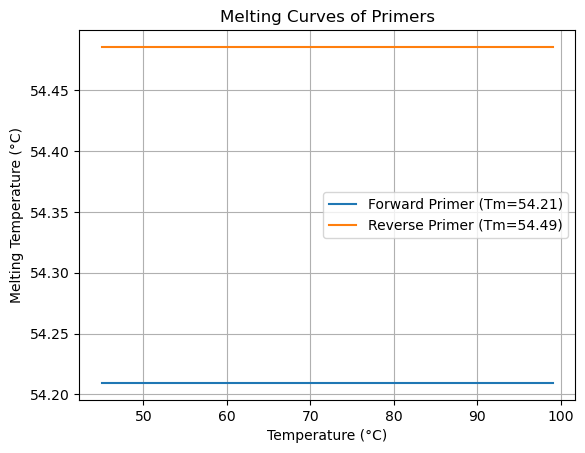

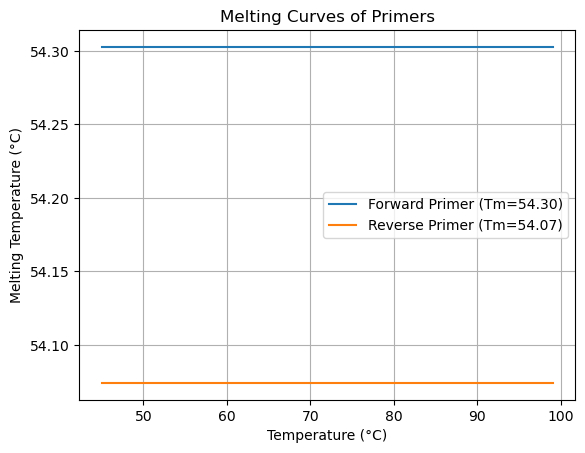

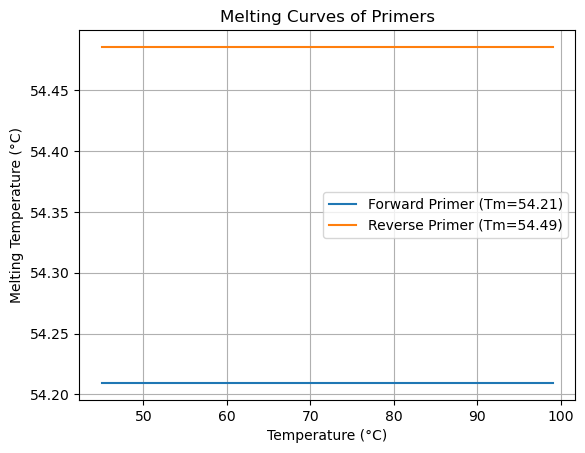

In [5]:
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp, gc_fraction
import matplotlib.pyplot as plt
import numpy as np
from primer3 import calc_heterodimer

def check_primer_dimers(forward_primer, reverse_primer):
    # Calculate the dimer information using primer3-py
    dimer_info = calc_heterodimer(forward_primer, reverse_primer)
    return dimer_info.dg, dimer_info.tm

def check_primer_quality(forward_primer, reverse_primer):
    # Calculate primer length
    primer_length_forward = len(forward_primer)
    primer_length_reverse = len(reverse_primer)

    # Calculate GC content as a fraction
    gc_content_forward = gc_fraction(forward_primer)
    gc_content_reverse = gc_fraction(reverse_primer)

    # Check for optimal primer length (adjust the thresholds as needed)
    optimal_length = 18 <= primer_length_forward <= 25 and 18 <= primer_length_reverse <= 25

    # Check for similar melting temperatures (adjust the threshold as needed)
    similar_tm = abs(MeltingTemp.Tm_NN(Seq(forward_primer)) - MeltingTemp.Tm_NN(Seq(reverse_primer))) <= 2

    # Check for optimal GC content (adjust the thresholds as needed)
    optimal_gc = 0.4 <= gc_content_forward <= 0.6 and 0.4 <= gc_content_reverse <= 0.6

    return optimal_length, similar_tm, optimal_gc

def visualize_primer_dimer(forward_primer, reverse_primer):
    # Plot melting curves for the forward and reverse primers
    forward_seq = Seq(forward_primer)
    reverse_seq = Seq(reverse_primer)

    tm_forward = MeltingTemp.Tm_NN(forward_seq)
    tm_reverse = MeltingTemp.Tm_NN(reverse_seq)

    temperatures = np.arange(45, 100)
    melting_curve_forward = [MeltingTemp.Tm_NN(forward_seq)] * len(temperatures)
    melting_curve_reverse = [MeltingTemp.Tm_NN(reverse_seq)] * len(temperatures)

    plt.plot(temperatures, melting_curve_forward, label=f"Forward Primer (Tm={tm_forward:.2f})")
    plt.plot(temperatures, melting_curve_reverse, label=f"Reverse Primer (Tm={tm_reverse:.2f})")

    plt.xlabel('Temperature (°C)')
    plt.ylabel('Melting Temperature (°C)')
    plt.title('Melting Curves of Primers')
    plt.legend()
    plt.grid(True)
    plt.show()

def main():
    # Read primer pairs from the file
    primer_file_path = r"C:\Users\AFRAA\OneDrive\Documents\primer_pairs.txt"
    output_file_path = r"C:\Users\AFRAA\OneDrive\Documents\primer_dimer_results.txt"

    with open(primer_file_path, 'r') as file:
        lines = file.readlines()

    # Open the output file for writing results
    with open(output_file_path, 'w') as output_file:
        # Write extended header to the output file
        output_file.write("Forward Primer\tReverse Primer\tDimer Delta G\tDimer Tm\tOptimal Length\tSimilar Tm\tOptimal GC\n")

        # Process each line in the input file
        for line in lines[1:]:  # Skip the header line
            fields = line.strip().split('\t')
            forward_primer = fields[0]
            reverse_primer = fields[1]

            # Check for primer dimers and get dimer information
            dimer_delta_g, dimer_tm = check_primer_dimers(forward_primer, reverse_primer)

            # Check primer quality
            optimal_length, similar_tm, optimal_gc = check_primer_quality(forward_primer, reverse_primer)

            # Write results to the output file
            output_file.write(f"{forward_primer}\t{reverse_primer}\t{dimer_delta_g:.2f}\t{dimer_tm:.2f}\t{optimal_length}\t{similar_tm}\t{optimal_gc}\n")

            # Visualize primer dimers
            visualize_primer_dimer(forward_primer, reverse_primer)

if __name__ == "__main__":
    main()


In [2]:
from Bio.Blast import NCBIWWW
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pandas as pd
import os
import time

# Path to the input primer pairs file
input_file_path = r"C:\Users\AFRAA\OneDrive\Documents\primer_pairs.txt"

# Path to the output directory
output_directory = r"C:\Users\AFRAA\OneDrive\Documents\result"

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)

# Read primer pairs from the input file into a DataFrame
primers_df = pd.read_csv(input_file_path, delimiter='\t')

# Function to perform Primer-BLAST for a given primer pair
def run_primer_blast(forward_primer, reverse_primer, output_file):
    try:
        # Combine forward and reverse primers into a single sequence
        sequence = Seq(f'{forward_primer}{reverse_primer}')
        
        # Create a SeqRecord object for the sequence
        seq_record = SeqRecord(sequence, id=output_file, description="")
        
        # Perform Primer-BLAST
        result_handle = NCBIWWW.qblast(
            program="blastn",
            database="nr",  # Use the nr nucleotide database
            sequence=seq_record.format("fasta"),
            word_size=7,
            expect=100.0,
            hitlist_size=5,
            descriptions=5,
            alignments=5,
            entrez_query="txid3193[ORGN] OR txid10239[ORGN]",  # Update the entrez_query
        )
        
        # Save the result to a file
        output_file_path = os.path.join(output_directory, output_file)
        print(f"Saving BLAST result to {output_file_path}")
        with open(output_file_path, "w") as out_handle:
            result_content = result_handle.read()
            out_handle.write(result_content)
            print(f"Result size: {len(result_content)} bytes")
        
        # Close the result handle
        result_handle.close()
    except Exception as e:
        print(f"Error processing {output_file}: {e}")

# Iterate over rows in the DataFrame and perform Primer-BLAST
for index, row in primers_df.iterrows():
    forward_primer = row['Forward Primer']
    reverse_primer = row['Reverse Primer']
    
    # Run Primer-BLAST for the current primer pair
    output_file_name = f'primer_blast_result_{index}.xml'
    run_primer_blast(forward_primer, reverse_primer, output_file_name)
    
    # Add a delay to prevent throttling by NCBI servers
    time.sleep(5)

# Display a message indicating the completion of the Primer-BLAST for all primer pairs
print('Primer-BLAST completed for all primer pairs.')


Saving BLAST result to C:\Users\AFRAA\OneDrive\Documents\result\primer_blast_result_0.xml
Result size: 7918 bytes
Saving BLAST result to C:\Users\AFRAA\OneDrive\Documents\result\primer_blast_result_1.xml
Result size: 10646 bytes
Saving BLAST result to C:\Users\AFRAA\OneDrive\Documents\result\primer_blast_result_2.xml
Result size: 7918 bytes
Primer-BLAST completed for all primer pairs.


In [1]:
from Bio.Blast import NCBIXML
import pandas as pd
import os

# Directory where XML result files are stored
output_directory = r"C:\Users\AFRAA\OneDrive\Documents\result"

# Function to parse a single BLAST XML file and extract relevant information
def parse_blast_xml(xml_file_path):
    with open(xml_file_path) as result_handle:
        blast_records = NCBIXML.parse(result_handle)
        data = []
        for blast_record in blast_records:
            for alignment in blast_record.alignments:
                for hsp in alignment.hsps:
                    data.append({
                        'Primer Pair File': os.path.basename(xml_file_path),
                        'Hit ID': alignment.hit_id,
                        'Hit Description': alignment.hit_def,
                        'Alignment Length': hsp.align_length,
                        'E-value': hsp.expect,
                        'Score': hsp.score,
                        'Identity': hsp.identities,
                        'Gaps': hsp.gaps,
                    })
        return pd.DataFrame(data)

# Parse all XML files in the output directory
result_files = [f for f in os.listdir(output_directory) if f.endswith('.xml')]
all_results = []

for xml_file in result_files:
    xml_file_path = os.path.join(output_directory, xml_file)
    print(f"Parsing {xml_file_path}")
    try:
        df = parse_blast_xml(xml_file_path)
        if not df.empty:
            all_results.append(df)
    except Exception as e:
        print(f"Error parsing {xml_file_path}: {e}")

# Combine all results into a single DataFrame
if all_results:
    final_results = pd.concat(all_results, ignore_index=True)
else:
    final_results = pd.DataFrame(columns=['Primer Pair File', 'Hit ID', 'Hit Description', 
                                          'Alignment Length', 'E-value', 'Score', 'Identity', 'Gaps'])

# Save the results to a CSV file
output_csv_path = os.path.join(output_directory, "all_primer_blast_results.csv")
final_results.to_csv(output_csv_path, index=False)

print(f"All results saved to {output_csv_path}")


Parsing C:\Users\AFRAA\OneDrive\Documents\result\primer_blast_result_0.xml
Parsing C:\Users\AFRAA\OneDrive\Documents\result\primer_blast_result_1.xml
Parsing C:\Users\AFRAA\OneDrive\Documents\result\primer_blast_result_2.xml
All results saved to C:\Users\AFRAA\OneDrive\Documents\result\all_primer_blast_results.csv
